In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from astropy.io import ascii
from scipy.ndimage import gaussian_filter1d
np.set_printoptions(threshold=np.inf)


%matplotlib inline
plt.rcParams['figure.figsize'] = (20,10)

In [2]:
def read_data(file):
    a          = ascii.read(file)
    lbda       = a['wave']
    flux       = a['flux']
    flux_err   = a['e_flux']

    return lbda,flux,flux_err



[1205.09684766 1205.31324    1205.52963234 1205.74602467 1205.96241701
 1206.17880935 1206.39520169 1206.61159403 1206.82798637 1207.04437871
 1207.26077105 1207.47716339 1207.69355573 1207.90994808 1208.12634042
 1208.34273276 1208.5591251  1208.77551745 1208.99190979 1209.20830213
 1209.42469447 1209.64108682 1209.85747916 1210.07387151 1210.29026385
 1210.5066562  1210.72304854 1210.93944089 1211.15583323 1211.37222558
 1211.58861792 1211.80501027 1212.02140262 1212.23779496 1212.45418731
 1212.67057966 1212.88697201 1213.10336435 1213.3197567  1213.53614905
 1213.7525414  1213.96893375 1214.1853261  1214.40171845 1214.6181108
 1214.83450315 1215.0508955  1215.26728785 1215.4836802  1215.70007255
 1215.9164649  1216.13285725 1216.3492496  1216.56564196 1216.78203431
 1216.99842666 1217.21481901 1217.43121137 1217.64760372 1217.86399608
 1218.08038843 1218.29678078 1218.51317314 1218.72956549 1218.94595785
 1219.1623502  1219.37874256 1219.59513492 1219.81152727 1220.02791963
 1220.2

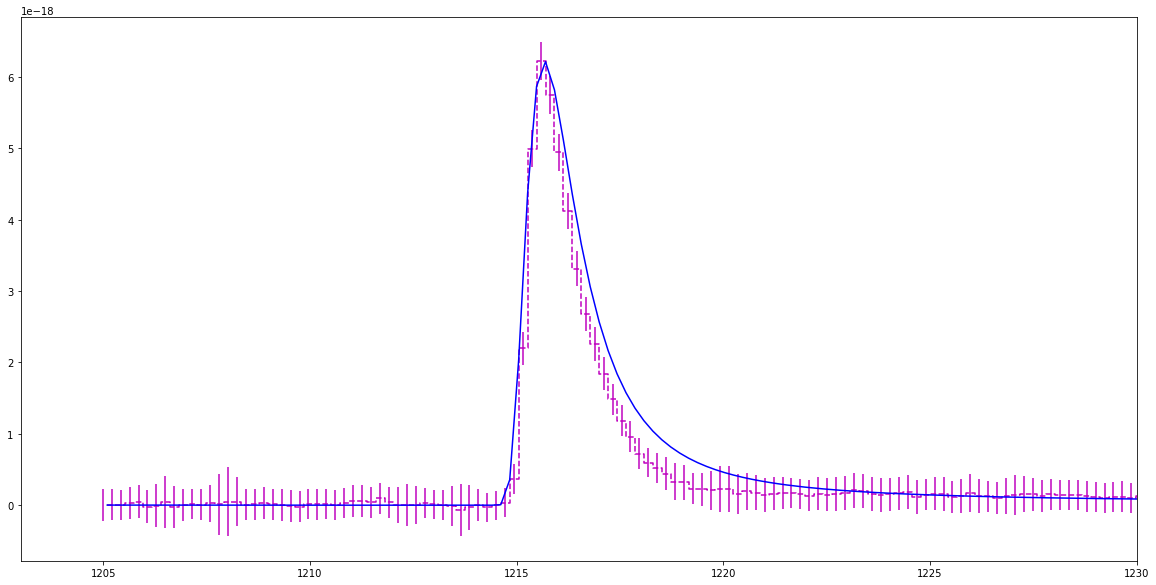

In [3]:
# Read data
datafile = 'data/sp_ref_amused_53.dat'
lbda,flux,flux_err = read_data(datafile)
flux_err = flux_err * 10.
#ii = np.where((lbda > 1205.) & (lbda < 1210.))[0]
#cont_data = np.mean(flux[ii])
#flux = flux / cont_data

plt.figure()

plt.xlim(1203.,1230.)
#plt.ylim(-5.*cont_data,10.*cont_data)

mi = 1205.
ma = 1240.

# Rebin data
flux2 = np.histogram(lbda, lbda, weights=flux,range=(mi, ma))[0] / np.histogram(lbda, lbda, range=(mi, ma))[0]
(bla,bin_edges) = np.histogram(lbda, lbda,range=(mi, ma))


flux_err2 = np.histogram(lbda, lbda, weights=flux_err,range=(mi, ma))[0] / np.histogram(lbda, lbda, range=(mi, ma))[0]
dlambda = bin_edges[10]-bin_edges[9]
lbda2   = 0.5*(bin_edges[:-1]+bin_edges[1:])-0.5*dlambda

uu=np.where((lbda2 > mi) & (lbda2 < ma))[0]
lbda2 = lbda2[uu]
flux2 = flux2[uu]
flux_err2 = flux_err2[uu]

max_fdata = np.max(flux2)

plt.step(lbda2,flux2,'m',linestyle='--',drawstyle='steps-mid')
plt.errorbar(lbda2-0.5*dlambda,flux2, yerr=flux_err2,c='m',linestyle='None')

print(lbda2)

ddd = 0.6
fff = max_fdata * np.exp(-(lbda2 - 1215.67)**2. / (2.*(0.3*(lbda2-1215.67)+ddd)**2))
plt.plot(lbda2,fff,'b')

plt.show()

In [4]:
def model(theta,l_model):
    # A_norm, a_asym, d_width, l_peak
    A_norm, a_asym, d_width, l_peak = theta
    f_model = A_norm * np.exp(-(l_model - l_peak)**2. / (2.*(a_asym*(l_model-l_peak)+d_width)**2))
    return f_model

def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

def lnprior(theta):
    A_norm, a_asym, d_width, l_peak = theta
    if 0.7*max_fdata < A_norm < 1.3*max_fdata and 0.05 < a_asym < 0.5 and 0.1 < d_width < 1.0 and 1215. < l_peak < 1216.:
        return 0.0
    return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [5]:
def run_model(lbda2,flux2,flux_err2):
    
    data = (lbda2, flux2,flux_err2)
    nwalkers = 1000
    discard=5000
    nits = 1000
    initial = np.array([max_fdata, 0.3, 0.6, 1215.67])
    ndim = len(initial)

    # Initialize the model
    A2_start = np.ones(nwalkers) * initial[0] + initial[0]*np.random.normal(0,0.1,nwalkers)
    a2_start = np.ones(nwalkers) * initial[1] + np.random.normal(0,0.1,nwalkers)
    d2_start = np.ones(nwalkers) * initial[2] + np.random.normal(0,0.1,nwalkers)
    lp2_start = np.ones(nwalkers) * initial[3] + np.random.normal(0,0.1,nwalkers)

    pos = np.vstack((A2_start,a2_start,d2_start,lp2_start)).T

    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob,
        args=(lbda2,flux2,flux_err2)
    )
    sampler.run_mcmc(pos, nits, progress=True)

    flat_samples = sampler.get_chain(discard=discard, flat=True) 

    return flat_samples,sampler



In [6]:
flat_samples,sampler = run_model(lbda2,flux2,flux_err2)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]/Users/tgarel/Library/Python/3.8/lib/python/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|███████████████████████████████████████| 1000/1000 [00:46<00:00, 21.72it/s]


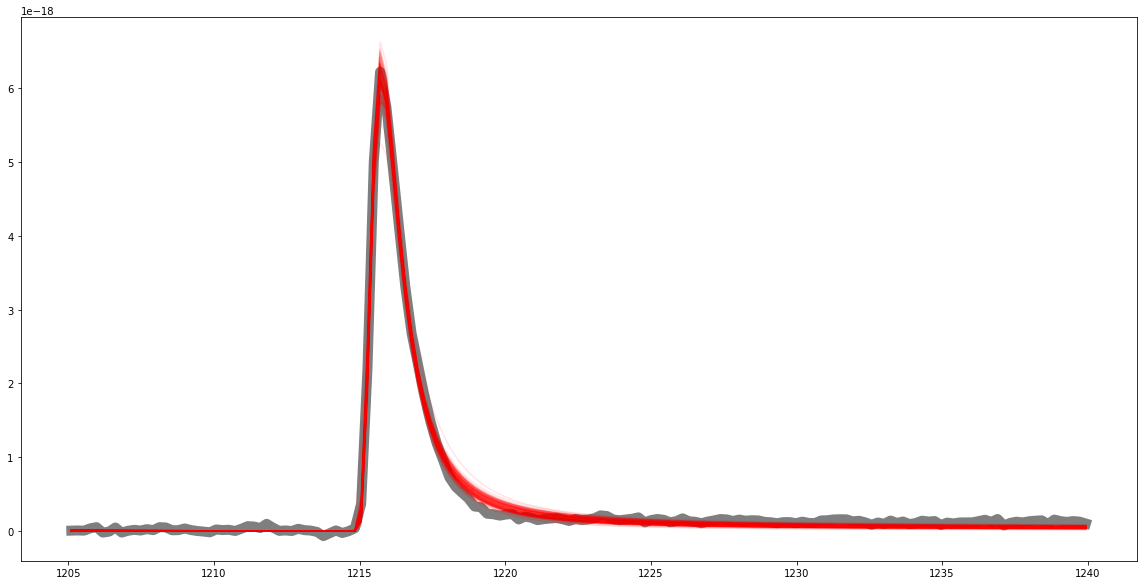

In [7]:
def plotter(sampler,lbda2=lbda2,flux2=flux2):
    plt.ion()
    plt.plot(lbda2,flux2,label='Spectrum',color='k',alpha=0.5,lw=10)
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(lbda2, model(theta, lbda2), color="r", alpha=0.1)
    #plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    #plt.xlabel('Years ago')
    #plt.ylabel(r'$\Delta$ T (degrees)')
    #plt.legend()
    plt.show()

plotter(sampler)


In [8]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([6.17969096e-18, 3.01420385e-01, 4.76679165e-01, 1.21574251e+03])

In [9]:
theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max,lbda2)

In [10]:
print('Theta max: ',theta_max)


Theta max:  [6.17969096e-18 3.01420385e-01 4.76679165e-01 1.21574251e+03]


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


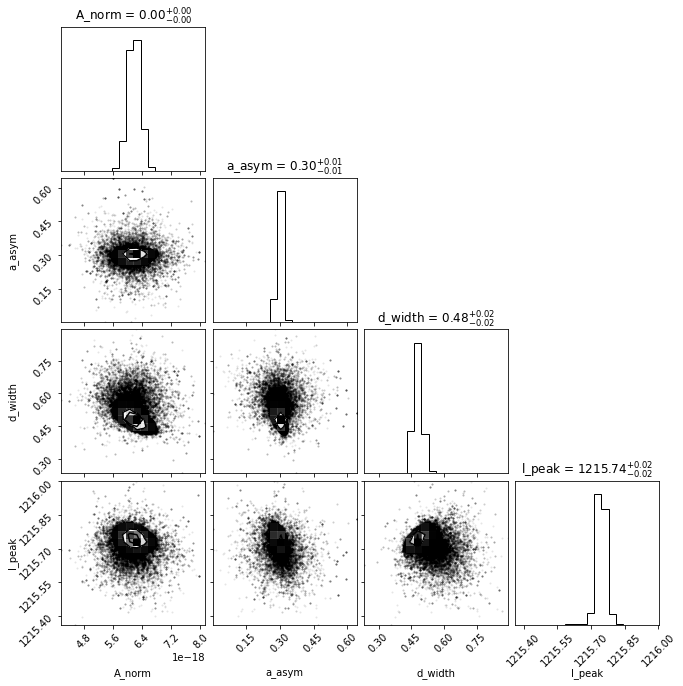

In [11]:
labels = ['A_norm','a_asym', 'd_width', 'l_peak']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True)#,quantiles=[0.16, 0.5, 0.84])


In [107]:
np.random.normal(1,0.1,5)

array([1.07880802, 0.85255979, 1.19966174, 1.13863007, 1.03006085])